# **Evaluate your best model on the whole dataset**

---



In [2]:
from google.colab import files

%matplotlib inline

import os

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model, load_model

import matplotlib.pyplot as plt

%matplotlib inline

from os import listdir
from os.path import isfile, join
import shutil
import stat
import collections
from collections import defaultdict

import h5py
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.applications.inception_v3 import preprocess_input

Using TensorFlow backend.


**Upload following files:**


*   train.txt
*   test.txt
*   cookies.txt (session from OneDrive)
*   client_secrets.json (Upload trained model to Google Drive)



In [17]:
from google.colab import files
uploaded = files.upload()

with open("client_secrets.json", 'wb') as f:
    f.write(uploaded[list(uploaded.keys())[0]])

Saving client_secrets.json to client_secrets.json


**Download following files and unzip them:**

*   chunk_1.zip
*   chunk_2.zip

If existing model wants to be continued learning:

*   inceptionv3_newest.hdf5

In [0]:
!mkdir images

In [5]:
!curl -b cookies.txt https://kantiolten-my.sharepoint.com/personal/muriz_serifovic_kantiolten_ch/_layouts/15/download.aspx?SourceUrl=%2Fpersonal%2Fmuriz%5Fserifovic%5Fkantiolten%5Fch%2FDocuments%2FMachine%20Learning%2Fimages%2Fchunk%5F1%2Ezip > chunk_1.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7861M  100 7861M    0     0  19.6M      0  0:06:40  0:06:40 --:--:-- 23.8M


In [6]:
!unzip -q chunk_1.zip -d images

warning [chunk_1.zip]:  4294967296 extra bytes at beginning or within zipfile
  (attempting to process anyway)
file #1:  bad zipfile offset (local header sig):  4294967296
  (attempting to re-compensate)
file #103498:  bad zipfile offset (local header sig):  10424
  (attempting to re-compensate)


In [0]:
!rm chunk_1.zip

In [1]:
!ls

datalab


In [8]:
!curl -b cookies.txt https://kantiolten-my.sharepoint.com/personal/muriz_serifovic_kantiolten_ch/_layouts/15/download.aspx?SourceUrl=%2Fpersonal%2Fmuriz%5Fserifovic%5Fkantiolten%5Fch%2FDocuments%2FMachine%20Learning%2Fimages%2Fchunk%5F2%2Ezip > chunk_2.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 8107M  100 8107M    0     0  19.9M      0  0:06:46  0:06:46 --:--:-- 21.8M


In [9]:
!unzip -q chunk_2.zip -d images

warning [chunk_2.zip]:  4294967296 extra bytes at beginning or within zipfile
  (attempting to process anyway)
file #1:  bad zipfile offset (local header sig):  4294967296
  (attempting to re-compensate)
file #103288:  bad zipfile offset (local header sig):  45211
  (attempting to re-compensate)


In [0]:
!rm chunk_2.zip

In [0]:
!rm -r images/__MACOSX/

In [12]:
!find images -print | wc -l 

404127


In [0]:
!find images -name "*.jpg" -size -1k -delete

In [14]:
!curl -b cookies.txt https://kantiolten-my.sharepoint.com/personal/muriz_serifovic_kantiolten_ch/_layouts/15/download.aspx?SourceUrl=%2Fpersonal%2Fmuriz%5Fserifovic%5Fkantiolten%5Fch%2FDocuments%2FMachine%20Learning%2Fmodels%2Finceptionv3%5F3%2Ehdf5 > inception_best.hdf5

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  170M  100  170M    0     0  21.3M      0  0:00:08  0:00:08 --:--:-- 28.3M


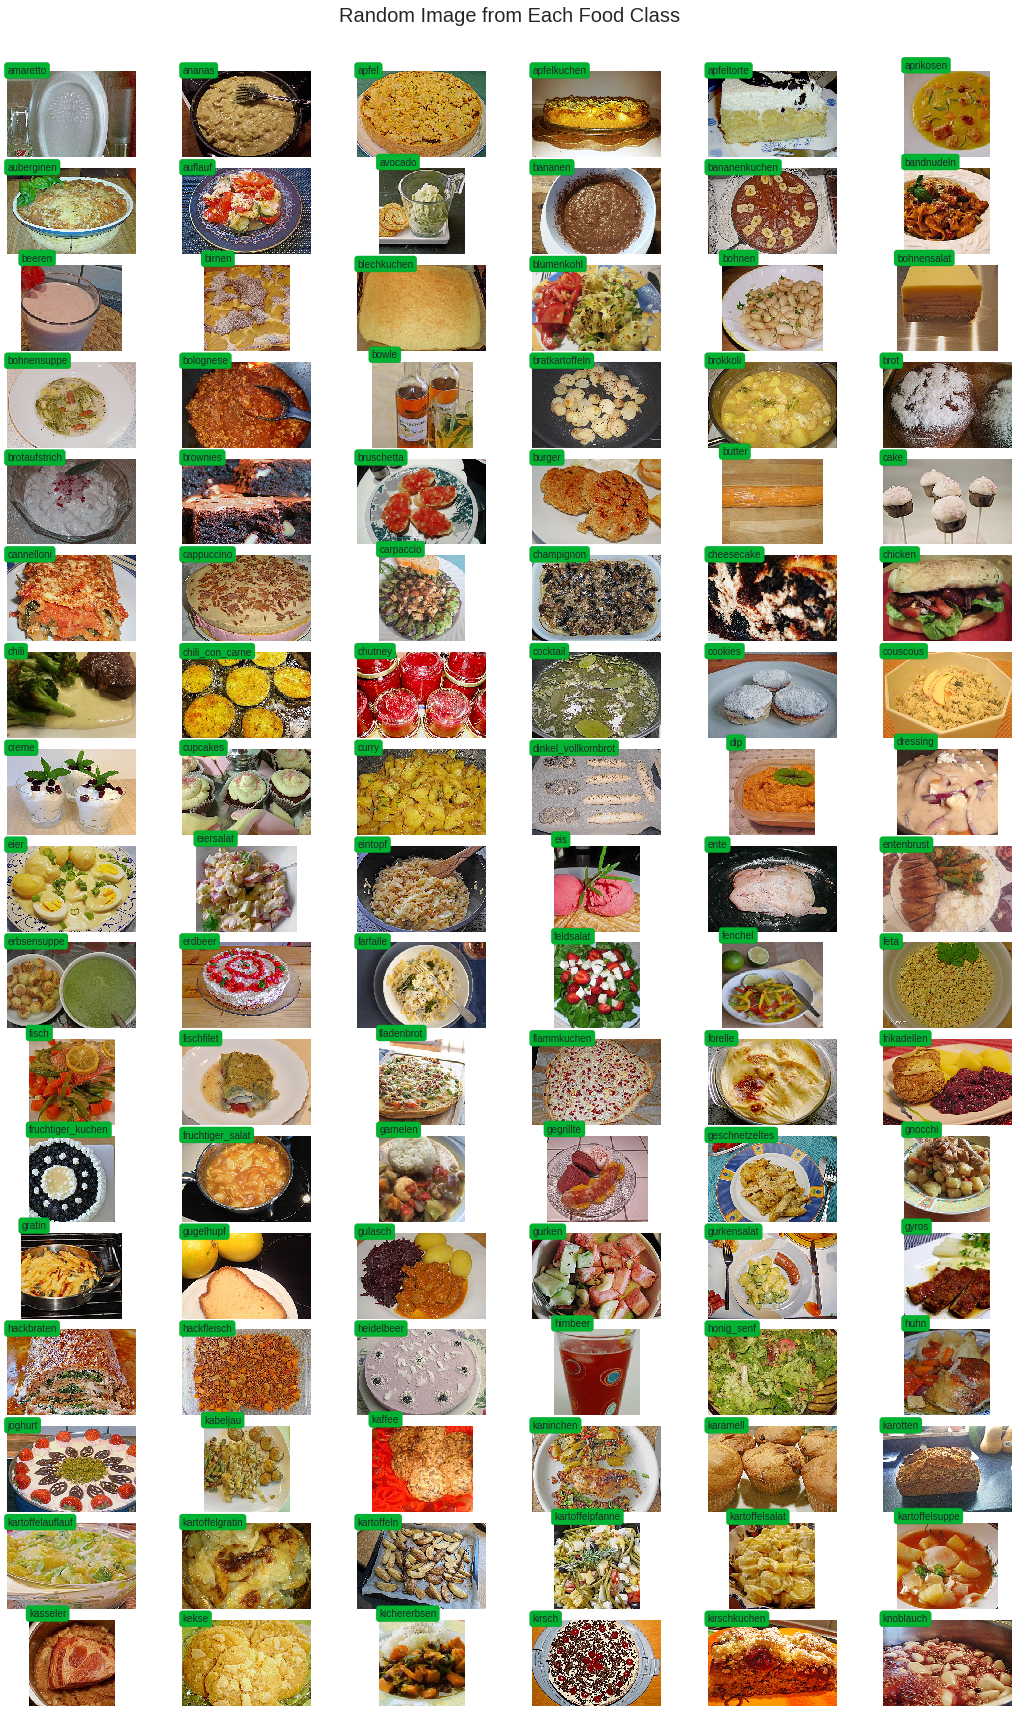

In [18]:
root_dir = 'images/'
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, frameon=False, figsize=(15, 25))
fig.suptitle('Random Image from Each Food Class', fontsize=20)
sorted_food_dirs = sorted(os.listdir(root_dir))
for i in range(rows):
    for j in range(cols):
        try:
            food_dir = sorted_food_dirs[i*cols + j]
        except:
            break
        all_files = os.listdir(os.path.join(root_dir, food_dir))
        rand_img = np.random.choice(all_files)
        img = plt.imread(os.path.join(root_dir, food_dir, rand_img))
        ax[i][j].imshow(img)
        ec = (0, .6, .1)
        fc = (0, .7, .2)
        ax[i][j].text(0, -20, food_dir, size=10, rotation=0,
                ha="left", va="top", 
                bbox=dict(boxstyle="round", ec=ec, fc=fc))
plt.setp(ax, xticks=[], yticks=[])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [0]:
# Only split files if haven't already
if not os.path.isdir('test') and not os.path.isdir('train'):

    def copytree(src, dst, symlinks = False, ignore = None):
        if not os.path.exists(dst):
            os.makedirs(dst)
            shutil.copystat(src, dst)
        lst = os.listdir(src)
        if ignore:
            excl = ignore(src, lst)
            lst = [x for x in lst if x not in excl]
        for item in lst:
            s = os.path.join(src, item)
            d = os.path.join(dst, item)
            if symlinks and os.path.islink(s):
                if os.path.lexists(d):
                    os.remove(d)
                os.symlink(os.readlink(s), d)
                try:
                    st = os.lstat(s)
                    mode = stat.S_IMODE(st.st_mode)
                    os.lchmod(d, mode)
                except:
                    pass # lchmod not available
            elif os.path.isdir(s):
                copytree(s, d, symlinks, ignore)
            else:
                shutil.copy2(s, d)

    def generate_dir_file_map(path):
        dir_files = defaultdict(list)
        with open(path, 'r') as txt:
            files = [l.strip() for l in txt.readlines()]
            for f in files:
                dir_name, id = f.split('/')
                dir_files[dir_name].append(id + '.jpg')
        return dir_files

    train_dir_files = generate_dir_file_map('train.txt')
    test_dir_files = generate_dir_file_map('test.txt')


    def ignore_train(d, filenames):
        print(d)
        subdir = d.split('/')[-1]
        to_ignore = train_dir_files[subdir]
        return to_ignore

    def ignore_test(d, filenames):
        print(d)
        subdir = d.split('/')[-1]
        to_ignore = test_dir_files[subdir]
        return to_ignore

    copytree('images', 'test', ignore=ignore_train)
    copytree('images', 'train', ignore=ignore_test)
    
else:
    print('Train/Test files already copied into separate folders.')

In [19]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5081981378765746576, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11288962663
 locality {
   bus_id: 1
 }
 incarnation: 5526070030417072469
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [20]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         359G   23G  318G   7% /
tmpfs           6.4G     0  6.4G   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
/dev/root       1.2G  537M  684M  44% /opt/bin
tmpfs           6.4G  220M  6.2G   4% /usr/lib64-nvidia
/dev/sda1       365G   39G  327G  11% /etc/hosts
shm              64M     0   64M   0% /dev/shm
tmpfs           6.4G     0  6.4G   0% /sys/firmware


In [21]:
import psutil
psutil.virtual_memory()

svmem(total=13662035968, available=10806849536, percent=20.9, used=13140021248, free=522014720, active=3088883712, inactive=8252157952, buffers=177426432, cached=10107408384, shared=233365504)

In [0]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, ReduceLROnPlateau
from keras.optimizers import SGD
from keras.regularizers import l2
import keras.backend as K
import math

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.layers import Input

In [0]:
inc = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=(299, 299, 3)))

87916544/87910968 [==============================] - 4s 0us/step


In [0]:
# add a global spatial average pooling layer
x = inc.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 2 classes
predictions = Dense(230, activation='softmax')(x)

model = Model(inputs=inc.input, outputs=predictions)

#model = load_model(filepath='inceptionv3_3.hdf5')

#opt = SGD(lr=0.01, momentum=.9)
for layer in inc.layers:
  layer.trainable = False
model.compile(optimizer="rmsprop", loss='categorical_crossentropy', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='inceptionv3_5.hdf5', verbose=1, save_best_only=True)

batch_size = 64

train_datagen = ImageDataGenerator(rescale=1./255,
                   rotation_range=10,
                   width_shift_range=0.05,
                   height_shift_range=0.05,
                   zoom_range=0.2,  # 0.75,
                   channel_shift_range=10,
                   shear_range=0.05,
                   horizontal_flip=True,
                   fill_mode="constant")

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'train',  # this is the target directory
        target_size=(299, 299),
        batch_size=batch_size,
        shuffle = True,
        class_mode='categorical')

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'test',
        target_size=(299, 299),
        batch_size=batch_size,
        shuffle = True,
       class_mode='categorical')


history = model.fit_generator(train_generator,
                    validation_data=validation_generator,
                    epochs=2,
                    verbose=1,
                    callbacks= [checkpointer])

Found 323189 images belonging to 230 classes.
Found 80696 images belonging to 230 classes.
Epoch 1/2
5050/5050 [==============================] - 10230s 2s/step - loss: 4.4419 - acc: 0.1163 - val_loss: 4.8305 - val_acc: 0.1029>.] - ETA: 1s - loss: 4.4420 - acc: 0.116

Epoch 00001: val_loss improved from inf to 4.83049, saving model to inceptionv3_5.hdf5
Epoch 2/2
5050/5050 [==============================] - 10141s 2s/step - loss: 4.3929 - acc: 0.1242 - val_loss: 4.7246 - val_acc: 0.1034>.] - ETA: 1s - loss: 4.3929 - acc: 0.124

Epoch 00002: val_loss improved from 4.83049 to 4.72465, saving model to inceptionv3_5.hdf5


In [0]:
opt = SGD(lr=0.001, momentum=.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='inceptionv3_3_1.hdf5', verbose=1, save_best_only=True)
model.fit_generator(train_generator,
                    validation_data=validation_generator,
                    epochs=1,
                    verbose=1,
                    callbacks= [checkpointer])

In [26]:
model = load_model(filepath='inception_best.hdf5')

train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'images',  # this is the target directory
        target_size=(299, 299),
        batch_size=64,
        shuffle = True,
        class_mode='categorical')

(eval_loss, eval_accuracy) = model.evaluate_generator(train_generator)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))
print("[INFO] Loss: {}".format(eval_loss))

Found 403885 images belonging to 230 classes.
[INFO] accuracy: 37.99%
[INFO] Loss: 2.8274242697566447


In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

textfile = drive.CreateFile()
textfile.SetContentFile('inceptionv3_5.hdf5')
textfile.Upload()